# Download dataset from kaggle

In [ ]:
from google.colab import files

! pip install -q kaggle
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d amanneo/diabetic-retinopathy-resized-arranged -p ./data/ --unzip

100% 1.21G/1.21G [00:13<00:00, 118MB/s] 
100% 1.21G/1.21G [00:13<00:00, 94.5MB/s]


# Make dataframe


0 - No DR
1 - Mild
2 - Moderate
3 - Severe
4 - Proliferative DR

In [ ]:
import os
import re
import pandas as pd

def define_paths(dir):
  desc = {
      '0' : '0 - No DR',
      '1' : '1 - Mild',
      '2' : '2 - Moderate',
      '3' : '3 - Severe',
      '4' : '4 - Proliferative DR'
  }

  files_path = []
  LR = []
  classes = []
  folders = os.listdir(dir)
  for folder in folders:
    folder_path = os.path.join(dir, folder)
    file_list = os.listdir(folder_path)
    for file_name in file_list:
      fpath = os.path.join(folder_path, file_name)
      regex_result = re.search(r"_(.*)\.", fpath)
      # append to the list
      files_path.append(fpath)
      LR.append(regex_result.group(1))
      classes.append(desc[folder])
  return files_path, LR, classes

def define_df(files, LR, classes):
  file_series = pd.Series(files, name= 'file_paths')
  LR_series = pd.Series(LR, name='LR')
  class_series = pd.Series(classes, name='class')
  return pd.concat([file_series, LR_series, class_series,], axis= 1)

def make_df(dir):
  files, LR, classes = define_paths(dir)
  df = define_df(files, LR, classes)
  return df

In [ ]:
df = make_df('./data/')
df

,file_paths,LR,class
0,./data/2/4352_right.jpeg,right,2 - Moderate
1,./data/2/40552_right.jpeg,right,2 - Moderate
2,./data/2/3237_left.jpeg,left,2 - Moderate
3,./data/2/23852_left.jpeg,left,2 - Moderate
4,./data/2/28369_left.jpeg,left,2 - Moderate
...,...,...,...
35121,./data/1/18014_left.jpeg,left,1 - Mild
35122,./data/1/10762_left.jpeg,left,1 - Mild
35123,./data/1/8275_right.jpeg,right,1 - Mild
35124,./data/1/25390_right.jpeg,right,1 - Mild


In [ ]:
print(df.groupby(['class', 'LR']).count())
print()
print(df.groupby(['LR']).count())

                            file_paths
class                LR               
0 - No DR            left        12871
                     right       12939
1 - Mild             left         1212
                     right        1231
2 - Moderate         left         2702
                     right        2590
3 - Severe           left          425
                     right         448
4 - Proliferative DR left          353
                     right         355

       file_paths  class
LR                      
left        17563  17563
right       17563  17563


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35126 entries, 0 to 35125
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_paths  35126 non-null  object
 1   LR          35126 non-null  object
 2   class       35126 non-null  object
dtypes: object(3)
memory usage: 823.4+ KB


In [ ]:
df.describe()

,file_paths,LR,class
count,35126,35126,35126
unique,35126,2,5
top,./data/2/4352_right.jpeg,right,0 - No DR
freq,1,17563,25810


# Exploratory Data Analysis (EDA)

In [ ]:
df.isnull().sum()

file_paths    0
LR            0
class         0
dtype: int64

In [ ]:
def plot(df, column):
  count = df[column].value_counts()
  percent = 100*df[column].value_counts(normalize=True)
  df = pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)})
  print(df)
  count.plot(kind='bar', title=column);

def plot_two_var(df, columns, divider):
  count = df.groupby(columns).file_paths.count().unstack(divider)
  print(count)
  count.plot.bar()

                      jumlah sampel  persentase
0 - No DR                     25810        73.5
2 - Moderate                   5292        15.1
1 - Mild                       2443         7.0
3 - Severe                      873         2.5
4 - Proliferative DR            708         2.0


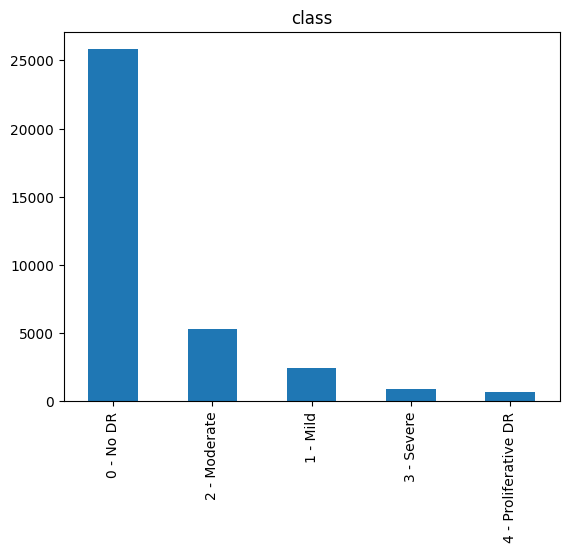

In [ ]:
plot(df, 'class')

       jumlah sampel  persentase
right          17563        50.0
left           17563        50.0


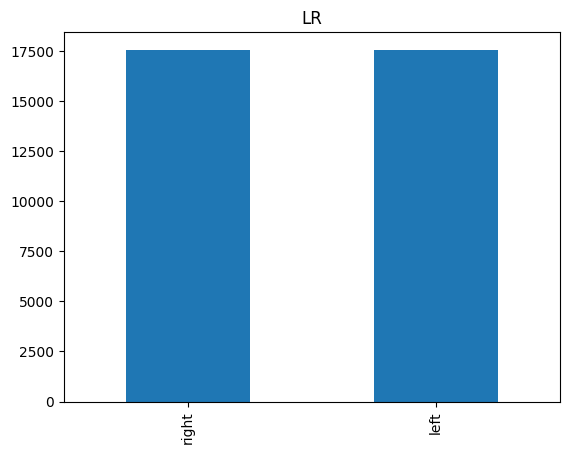

In [ ]:
plot(df, 'LR')

LR                     left  right
class                             
0 - No DR             12871  12939
1 - Mild               1212   1231
2 - Moderate           2702   2590
3 - Severe              425    448
4 - Proliferative DR    353    355


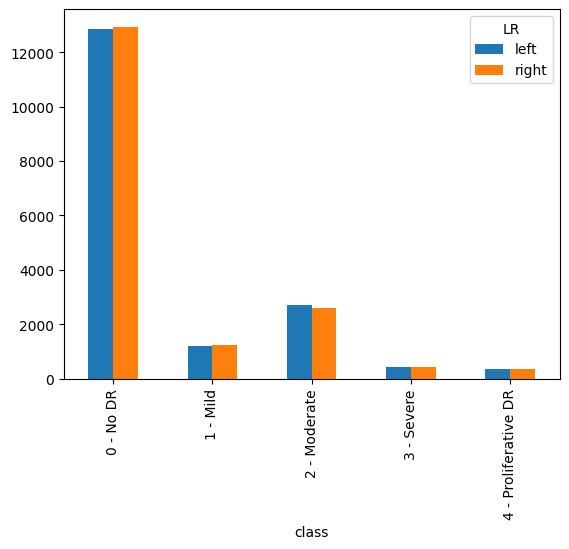

In [ ]:
# pd.pivot_table(df,index = 'class',
#                columns = 'LR', aggfunc ='count').plot.bar()

# count = df.groupby(['class', 'LR']).file_paths.count().unstack('LR')
# print(count)
# count.plot.bar()


plot_two_var(df, ['class', 'LR'], 'LR')

# Take 700 samples per class

In [ ]:
def take_n_sample_per_class(df, n, classes, random_state=42):
  new_df = pd.DataFrame()
  for i in classes:
    right_df = df.loc[(df['class'] == i)&(df['LR'] == 'right')].sample(n//2, random_state=random_state)
    left_df = df.loc[(df['class'] == i)&(df['LR'] == 'left')].sample(n//2, random_state=random_state)
    new_df = pd.concat([new_df, right_df, left_df])
  return new_df

def train_dev_test_split(df, train_rasio, dev_rasio, test_rasio):
  train_df = pd.DataFrame()
  dev_df = pd.DataFrame()
  test_df = pd.DataFrame()

  for i in df['class'].unique():
    right_df = df.loc[(df['class'] == i)&(df['LR'] == 'right')]
    left_df = df.loc[(df['class'] == i)&(df['LR'] == 'left')]
    train_len = int(len(right_df)*train_rasio)
    dev_len = int(len(right_df)*dev_rasio)
    test_len = int(len(right_df)*test_rasio)
    train_df = pd.concat([train_df, right_df[:train_len], left_df[:train_len]])
    dev_df = pd.concat([dev_df, right_df[train_len:train_len+dev_len], left_df[train_len:train_len+dev_len]])
    test_df = pd.concat([test_df, right_df[-test_len:], left_df[-test_len:]])
  return train_df, dev_df, test_df
  

In [ ]:
classes = df['class'].unique()

new_df = take_n_sample_per_class(df, 700, classes, 123)
new_df

,file_paths,LR,class
75,./data/2/20175_right.jpeg,right,2 - Moderate
2635,./data/2/44214_right.jpeg,right,2 - Moderate
3520,./data/2/34775_right.jpeg,right,2 - Moderate
185,./data/2/18970_right.jpeg,right,2 - Moderate
2110,./data/2/10319_right.jpeg,right,2 - Moderate
...,...,...,...
33607,./data/1/17202_left.jpeg,left,1 - Mild
34562,./data/1/3017_left.jpeg,left,1 - Mild
33108,./data/1/8047_left.jpeg,left,1 - Mild
32770,./data/1/11446_left.jpeg,left,1 - Mild


In [ ]:
train_df, dev_df, test_df = train_dev_test_split(new_df, 0.8, 0.1, 0.1)

In [ ]:
train_df

,file_paths,LR,class
75,./data/2/20175_right.jpeg,right,2 - Moderate
2635,./data/2/44214_right.jpeg,right,2 - Moderate
3520,./data/2/34775_right.jpeg,right,2 - Moderate
185,./data/2/18970_right.jpeg,right,2 - Moderate
2110,./data/2/10319_right.jpeg,right,2 - Moderate
...,...,...,...
34855,./data/1/320_left.jpeg,left,1 - Mild
35067,./data/1/3722_left.jpeg,left,1 - Mild
33932,./data/1/8513_left.jpeg,left,1 - Mild
34007,./data/1/6732_left.jpeg,left,1 - Mild


In [ ]:
print('num of training set:', len(train_df))
print('num of dev set:', len(dev_df))
print('num of test set:', len(test_df))

num of training set: 2800
num of dev set: 350
num of test set: 350


LR                    left  right
class                            
0 - No DR              280    280
1 - Mild               280    280
2 - Moderate           280    280
3 - Severe             280    280
4 - Proliferative DR   280    280


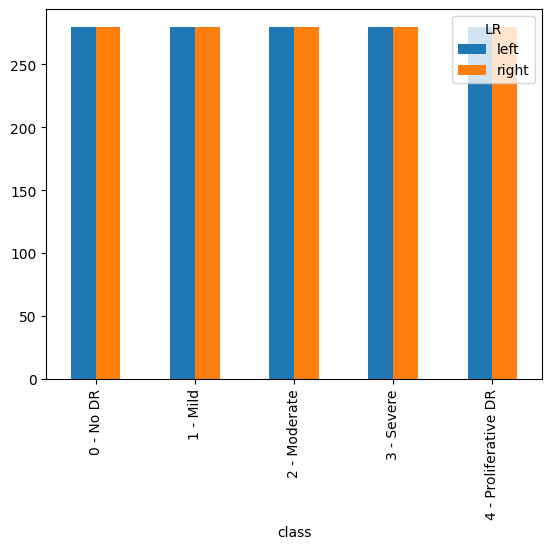

In [ ]:
plot_two_var(train_df, ['class', 'LR'], 'LR')


       jumlah sampel  persentase
right           1400        50.0
left            1400        50.0


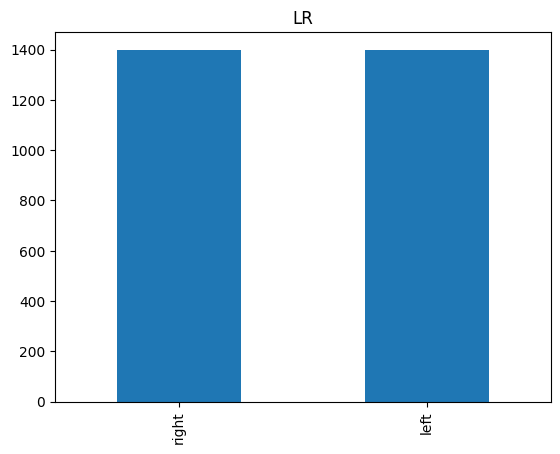

In [ ]:
plot(train_df, 'LR')

                      jumlah sampel  persentase
2 - Moderate                    560        20.0
3 - Severe                      560        20.0
4 - Proliferative DR            560        20.0
0 - No DR                       560        20.0
1 - Mild                        560        20.0


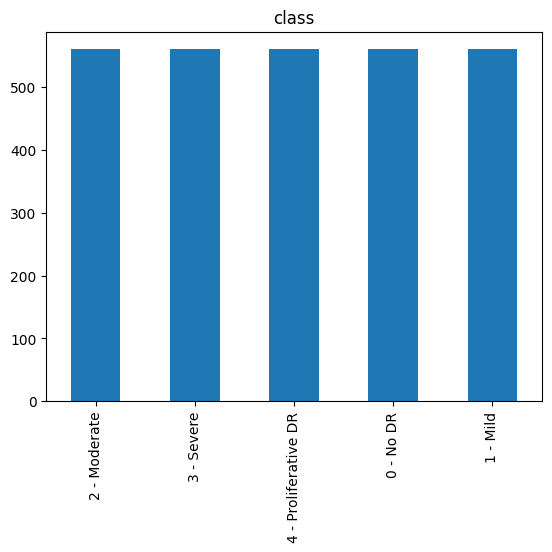

In [ ]:
plot(train_df, 'class')


In [ ]:
train_df.describe()

,file_paths,LR,class
count,2800,2800,2800
unique,2800,2,5
top,./data/2/20175_right.jpeg,right,2 - Moderate
freq,1,1400,560


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch = 32
ts_len = len(test_df)
test_batch = max(sorted([ts_len // n for n in range(1, ts_len + 1) if ts_len%n == 0 and ts_len/n <= 80]))

print(test_batch)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1
    )

dev_test_datagen = ImageDataGenerator(rescale=1./255)

print('\nFor training')
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col= 'file_paths',
    y_col= 'class',
    target_size=img_size,
    batch_size=batch,
    shuffle=True,
    seed=123,
    class_mode='categorical')

print('\nFor dev')
dev_generator = dev_test_datagen.flow_from_dataframe(
    dev_df,
    x_col= 'file_paths',
    y_col= 'class',
    target_size=img_size,
    batch_size=batch, 
    shuffle=False,
    class_mode='categorical')

print('\nFor test')
test_generator = dev_test_datagen.flow_from_dataframe(
    test_df,
    x_col= 'file_paths',
    y_col= 'class',
    target_size=img_size,
    batch_size=test_batch,
    shuffle=False,
    class_mode='categorical')

## Reshuffle the dataset

In [ ]:
train_df = train_df.sample(frac=1, random_state=123).reset_index(drop=True)
dev_df = dev_df.sample(frac=1, random_state=123).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=123).reset_index(drop=True)

In [ ]:
train_df

,file_paths,LR,class
0,./data/1/39650_right.jpeg,right,1 - Mild
1,./data/1/20808_left.jpeg,left,1 - Mild
2,./data/0/7682_right.jpeg,right,0 - No DR
3,./data/2/28904_left.jpeg,left,2 - Moderate
4,./data/3/23369_left.jpeg,left,3 - Severe
...,...,...,...
2795,./data/4/15459_right.jpeg,right,4 - Proliferative DR
2796,./data/0/14654_left.jpeg,left,0 - No DR
2797,./data/0/886_right.jpeg,right,0 - No DR
2798,./data/4/10785_right.jpeg,right,4 - Proliferative DR


# Save New Dataset

In [ ]:
new_df.to_csv('./new_df.csv',index=False)
files.download('./new_df.csv') 

train_df.to_csv('./dr_train_df.csv', index=False)
files.download('./dr_train_df.csv') 

dev_df.to_csv('./dr_dev_df.csv', index=False)
files.download('./dr_dev_df.csv') 

test_df.to_csv('./dr_test_df.csv', index=False)
files.download('./dr_test_df.csv') 



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>